In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exam Data Science I  
### Exam I in the Summer Term 2025

## General Information

* You have one week to complete the exam.

* You can use all sources freely (including ChatGPT or similar software)

* You should use the following packages: `numpy, pandas, scipy, scikit-learn/sklearn, matplotlib, seaborn, statsmodels` and Python's native libraries. These are sufficient to solve the exam. If you use other libraries, justify their use.

* Code must be sufficiently commented to be understandable. Write functions whenever you reuse code. In general, follow the guidelines from the lecture. Points may be deducted due to poorly structured or incomprehensible code.

* **Always justify (!)** decisions regarding the choice of plots, hypothesis tests, etc. in writing and **interpret** your results.

* You are **not** allowed to seek help or advice from other people in any way.

* Please submit the complete repository as a `.zip` file with the name `surname_matrikelnummer.zip` by August 4th, 2025 at 00:00 midnight on StudIP to the folder `Submission - Exam 1`.

* Also add the signed code of conduct (`Eigenständigkeitserklärung.pdf`) to the `.zip` file.

* If you have any questions, please contact us via Matrix in a timely manner.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import periodogram
from scipy.stats import zscore, mannwhitneyu
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.multitest import multipletests
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, FunctionTransformer
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree, export_text, DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## Tasks and points:

<table>
  <thead>
    <tr>
      <th colspan="4" style="border-right: 1px solid gray;">Task 1 - Data Preprocessing</th>
      <th colspan="5" style="border-right: 1px solid gray;">Task 2 - Plotting</th>
      <th colspan="3" style="border-right: 1px solid gray;">Task 3 - Statistics</th>
      <th colspan="2">Task 4 - Machine Learning </th>
    </tr>
    <tr style="border-bottom: 1px solid gray;">
      <th>Task 1.1</th>
      <th>Task 1.2</th>
      <th>Task 1.3</th>
      <th style="border-right: 1px solid gray;">Task 1.4</th>
      <th>Task 2.1</th>
      <th>Task 2.2</th>
      <th>Task 2.3</th>
      <th>Task 2.4</th>
      <th style="border-right: 1px solid gray;">Task 2.5</th>
      <th>Task 3.1</th>
      <th>Task 3.2</th>
      <th style="border-right: 1px solid gray;">Task 3.3</th>
      <th>Task 4.1</th>
      <th>Task 4.2</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>2 points</td>
      <td>11 points</td>
      <td>4 points</td>
      <td style="border-right: 1px solid gray;">2 points</td>
      <td>2 points</td>
      <td>14 points</td>
      <td>2 points</td>
      <td>4 points</td>
      <td style="border-right: 1px solid gray;">2 points</td>
      <td>6 points</td>
      <td>4 points</td>
      <td style="border-right: 1px solid gray;">7 points</td>
      <td>15 points</td>
      <td>25 points</td>
    </tr>
    <tr>
      <td colspan="4" style="text-align: center; font-weight: bold;border-right: 1px solid gray;">19 points</td>
      <td colspan="5" style="text-align: center; font-weight: bold;border-right: 1px solid gray;">24 points</td>
      <td colspan="3" style="text-align: center; font-weight: bold;border-right: 1px solid gray;">17 points</td>
      <td colspan="2" style="text-align: center; font-weight: bold;">40 points</td>
    </tr>
  </tbody>
</table>


_____
## Task 0: Setup

The exam folder includes a `Dockerfile` that defines all necessary libraries and a `docker-compose.yml` file. The Dockerfile is based on the Jupyter Server image. Use it to build a Docker image and then start a container from that image. Once the container is running, log into the Jupyter Server instance to complete the exam.

Alternatively, you may use the [GWDG Jupyter Cloud service](https://jupyter-cloud.gwdg.de/) with either the GWDG Default Image or the Data Science Jupyter Image.

Important:
If you choose to work in the Jupyter Cloud and to use additional packages, they must be installed within the notebook itself (e.g., using a cell with `!pip install ...`). This ensures your environment can be reproduced during grading.

Code that does not run in the provided Docker container or in the Jupyter Cloud environment will be considered **non-functional** and graded accordingly.

___
## Task 1: Data Preprocessing (18 points)

### Data Description

In this exam, we work with a [dataset](https://arxiv.org/abs/2404.18984) of social interactions and user-generated content from [Bluesky](https://bsky.social/about). The original dataset includes the full posting history of over 4 million users—approximately 81% of all registered accounts—amounting to 235 million posts. To make the data more manageable for analysis, we have pre-aggregated and condensed it into smaller, structured files.

Social media datasets frequently include a sentiment score, a numerical measure indicating the emotional tone of text content such as posts (0: negative, 1: neutral, 2: positive). Since sentiment scores are only available on English-language content in this dataset, we filtered the data to include only English-language posts. Additionally, we limited user interactions to those related exclusively to these filtered posts.

Our aggregated dataset consists out of three subdatasets: author interactions, user interactions and user's post statistics per day.

**Author interactions**
Contains aggregated statistics on how often posts from individual authors received different types of interactions. Each row corresponds to one unique author, identified by a numeric user ID.
- `author`: A unique identifier for each user.
- `replied_count`: The total number of replies received of posts made by the author.
- `reposted_count`: The total number of times the author’s posts were reposted by others.
- `quoted_count`: The number of times the author’s posts were quoted in other users' posts.

**User interactions**
Summarizes the interaction behavior of individual users—how often they engaged with posts by others. Each row represents one unique user, identified by a numeric user ID.
- `user_id`: A unique identifier for each user.
- `replied_count`: The total number of replies the user wrote in response to other posts.
- `reposted_count`: The total number of posts the user reposted.
- `quoted_count`: The number of times the user quoted other users' posts in their own.

**User's post statistics per day**
Provides daily statistics on user-generated posts. Each row represents the posting activity of a single user on a specific day.
- `date`: The calendar date on which the posts were made.
- `user_id`: A unique identifier for the user who authored the posts.
- `post_count`: The number of posts the user made on that day.
- `mean_sentiment`: The average sentiment score of the user’s posts on that day, indicating the overall emotional tone (e.g., positive, neutral, or negative).

### Task 1.1. - Data Loading (2 points)

Load the following datasets into pandas dataframes:
- `author_interaction_stats.csv.gz`
- `user_interaction_stats.csv.gz`
- `user_post_stats_per_day.csv.gz`

Ensure that the `date` column in `user_post_stats_per_day` is interpreted as a date—either during loading or by converting it afterward.

In [ ]:
#Load Datasets
author_interaction_stat= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Exam/author_interaction_stats.csv.gz")
print("Author interaction stat data shape  :", author_interaction_stat.shape)
#2nd data file
user_interaction_stats= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Exam/user_interaction_stats.csv.gz")
print("user_interaction_stats data shape  :", user_interaction_stats.shape)
# 3rd data file
user_post_stats_per_day=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Exam/user_post_stats_per_day.csv.gz")
user_post_stats_per_day["date"]=pd.to_datetime(user_post_stats_per_day["date"]) #convert to date and time format
print(user_post_stats_per_day["date"].dtype) #check the data type
print("user post stats per day data shape  :", user_post_stats_per_day.shape)

Author interaction stat data shape  : (1446169, 4)
user_interaction_stats data shape  : (1718043, 4)
datetime64[ns]
user post stats per day data shape  : (25391921, 4)


### Task 1.2. - Aggregation (11 points)

First, we are interested in trends over time. For this, aggregate the data for `user_post_stats_per_day` over all days and provide summary statistics for each day.
 - total number of posts per day
 - average sentiment across users per day
 - average sentiment across posts per day (hint: use a weighted mean here)

Make sure that the resulting DataFrame is indexed by the `date` column, stored as a proper `datetime` object.

In [ ]:
user_post_stats_per_day["weighted_sentiment"]= user_post_stats_per_day["post_count"]*user_post_stats_per_day["mean_sentiment"]
# Daily Statistical Summary
daily_summary= user_post_stats_per_day.groupby("date").agg(total_post=("post_count", "sum"),
                                                           avg_user_sentiment=("mean_sentiment", "mean"),
                                                           weighted_sentiment_sum=("weighted_sentiment", "sum"))

daily_summary["avg_sentiment_posts"]= ( daily_summary["weighted_sentiment_sum"]/ daily_summary["total_post"])

# drop the weighted sentimented sum column
daily_summary.drop(columns="weighted_sentiment_sum", inplace=True)
# Date column is the index coummn
daily_summary.index=pd.to_datetime(daily_summary.index)
daily_summary.head()

,total_post,avg_user_sentiment,avg_sentiment_posts
date,,,
2023-06-28,12230,1.053866,1.077419
2023-06-29,72447,0.953651,1.000038
2023-06-30,95774,0.968473,0.999022
2023-07-01,212055,1.011609,0.989611
2023-07-02,310227,1.009279,1.008060


Check, if all days within the period are present, or if one day was left out.

In [ ]:
full_date_range = pd.date_range(start=user_post_stats_per_day['date'].min(), end=user_post_stats_per_day['date'].max(), freq='D')

# Get the actual dates present in the dataset
present_dates = pd.to_datetime(user_post_stats_per_day['date'].unique())

# missing dates
missing_dates = full_date_range.difference(present_dates)

# loop to show the missing date
if missing_dates.empty:
    print(" All days within the period are present.")
else:
    print("Missing days detected:")
    print(missing_dates)

 All days within the period are present.


Additionally, we might want to look at individual users. Aggregate the `user_post_stats_per_day` dataset across all days to compute summary statistics for each user. Name the dataframe `user_stats` (easier for future referencing). Include the following features:
 - average sentiment (hint: use a weighted mean)
 - standard deviation of sentiment (without weighted mean)
 - total number of posts
 - average number of posts per day
 - number of active days
 - date of first post
 - date of last post

Additionally, compute temporal posting behavior using a custom function (note: this may take longer to compute):
- average number of days between posts
- median number of days between posts
- standard deviation of time between posts
- relative standard deviation or 'coefficient of variation (CV)' of the time between posts (defined as the standard deviation divided by the mean)

The coefficient of variation (CV) provides a normalized measure of posting regularity. A low CV indicates consistent posting intervals, while a high CV suggests irregular or bursty behavior. Unlike the standard deviation alone, the CV accounts for the user's average posting frequency, making comparisons between users more meaningful.

For example, a user who posts every 2 days on average with a standard deviation of 5 days has a CV of 2.5 — indicating high variability. Another user who posts every 20 days with the same standard deviation has a CV of 0.25 — indicating relatively regular behavior.

In [ ]:
user_stats=user_post_stats_per_day.groupby("user_id").agg(total_post=("post_count","sum"),
                                                        weighted_sentiment_sum=("mean_sentiment", "sum"),
                                                        sentiment_std=("mean_sentiment", "std"),
                                                        avg_daily_post=("post_count", "mean"),
                                                        active_days=("date", "nunique"),
                                                        first_post=("date", "min"),
                                                        last_post=("date", "max"))

user_stats["avg_sentiment"]=user_stats["weighted_sentiment_sum"]/ user_stats["total_post"]
user_stats.drop(columns="weighted_sentiment_sum",inplace=True )
user_stats.head()

,total_post,sentiment_std,avg_daily_post,active_days,first_post,last_post,avg_sentiment
user_id,,,,,,,
0,1404,0.235153,11.414634,123,2023-10-18,2024-03-18,0.036550
1,512,0.507907,3.390728,151,2023-07-02,2024-03-18,0.274207
2,5727,0.379932,29.520619,194,2023-07-28,2024-03-18,0.041258
3,10,0.644854,1.250000,8,2024-02-21,2024-03-04,0.939061
4,290,0.522817,2.685185,108,2023-08-20,2024-03-18,0.565866


In [ ]:
def compute_temporal_stats(group):
    dates = group.sort_values(by="date")['date'].drop_duplicates().values
    if len(dates) < 2:
        return pd.Series({
            'avg_days_between_posts': np.nan,
            'median_days_between_posts': np.nan,
            'std_days_between_posts': np.nan,
            'cv_days_between_posts': np.nan
        })

    gaps = np.diff(dates).astype('timedelta64[D]').astype(int)

    mean_gap = np.mean(gaps)
    std_gap = np.std(gaps, ddof=1)  # sample std
    cv = std_gap / mean_gap if mean_gap > 0 else np.nan

    return pd.Series({
        'avg_days_between_posts': mean_gap,
        'median_days_between_posts': np.median(gaps),
        'std_days_between_posts': std_gap,
        'cv_days_between_posts': cv
    })

# Apply temporal stats
temporal_stats = user_post_stats_per_day.groupby('user_id').apply(compute_temporal_stats)

# Combine with main user stats
user_stats = user_stats.join(temporal_stats)


:Instead of working with two individual columns for the dates of the first and last post, we want to make use of the information of the total time between them. Calculate the time between the dates of the first and last post in days and add it as a column. Delete the two date columns afterwards.

In [ ]:
user_stats["posting_span_days"]=(user_stats["last_post"]- user_stats["first_post"]).dt.days
user_stats.drop(columns=["first_post", "last_post"], inplace=True)
user_stats

,total_post,sentiment_std,avg_daily_post,active_days,avg_sentiment,posting_span_days
user_id,,,,,,
0,1404,0.235153,11.414634,123,0.036550,152
1,512,0.507907,3.390728,151,0.274207,260
2,5727,0.379932,29.520619,194,0.041258,234
3,10,0.644854,1.250000,8,0.939061,12
4,290,0.522817,2.685185,108,0.565866,211
...,...,...,...,...,...,...
4099350,2,0.707107,1.000000,2,1.500000,1
4099372,4,0.577350,1.333333,3,0.500000,15
4099408,16,0.495612,4.000000,4,0.147542,19


### Task 1.3. - Merging (4 points)

Merge the user-level dataset `user_stats` with interaction data from `user_interaction_stats` and `author_interaction_stats`. Perform the merges in two steps:
1. Left-merge `user_stats` with `user_interaction_stats`.
2. Merge the resulting dataset with `author_interaction_stats`, again using a left join.

This approach ensures that only users who have posted at least one English-language post (i.e., those present in `user_stats`) are included in the final dataset.

Note that both `user_interaction_stats` and `author_interaction_stats` contain columns for the total number of replies, reposts, and quotes. To avoid confusion, append the suffix `_by_others` to the columns from `author_interaction_stats`, as they reflect interactions received by the user (i.e., how others engaged with their posts). This distinction helps clarify whether the user was the actor (interaction made) or the target (interaction received).

In [ ]:
#  first step
merged=pd.merge(user_stats,user_interaction_stats,on="user_id", how="left")
#  Step 2
final_merge=pd.merge(merged, author_interaction_stat,left_on="user_id",right_on="author", how="left", suffixes=('', '_by_others') )
final_merge

,user_id,total_post,sentiment_std,avg_daily_post,active_days,avg_sentiment,posting_span_days,replied_count,reposted_count,quoted_count,author,replied_count_by_others,reposted_count_by_others,quoted_count_by_others
0,0,1404,0.235153,11.414634,123,0.036550,152,76.0,1398.0,306.0,0.0,8.0,4.0,0.0
1,1,512,0.507907,3.390728,151,0.274207,260,94.0,81.0,18.0,1.0,313.0,505.0,160.0
2,2,5727,0.379932,29.520619,194,0.041258,234,3674.0,557.0,444.0,2.0,3659.0,936.0,168.0
3,3,10,0.644854,1.250000,8,0.939061,12,NaN,NaN,NaN,3.0,89.0,340.0,79.0
4,4,290,0.522817,2.685185,108,0.565866,211,188.0,12.0,10.0,4.0,1788.0,17091.0,2463.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1236105,4099350,2,0.707107,1.000000,2,1.500000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1236106,4099372,4,0.577350,1.333333,3,0.500000,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1236107,4099408,16,0.495612,4.000000,4,0.147542,19,3.0,4.0,1.0,NaN,NaN,NaN,NaN
1236108,4099470,1,NaN,1.000000,1,1.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some users in the dataset have missing values in their engagement-related columns. These columns include both outgoing interactions and incoming interactions: `"replied_count", "reposted_count", "quoted_count", "replied_count_by_others", "reposted_count_by_others", "quoted_count_by_others"`.

Replace all missing values (NaN) in these columns with 0.

In [ ]:
# Replace the NaN values by 0
final_merge=final_merge.fillna(0)

### Task 1.4. - Save Dataframes (2 points)

Since the transformation took some time to compute we want to have it ready in case we close the kernel. Save both aggregated dataframes as .csv files in the first cell and load them again in the second cell. In case your notebook fails, you can resume from the second cell.

In [ ]:
final_merge.to_csv("/content/drive/MyDrive/Colab Notebooks/Exam/user_stat.csv", index=False)

In [ ]:
user_stats=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Exam/user_stat.csv")
user_stats.head()

,user_id,total_post,sentiment_std,avg_daily_post,active_days,avg_sentiment,avg_days_between_posts,median_days_between_posts,std_days_between_posts,cv_days_between_posts,posting_span_days,replied_count,reposted_count,quoted_count,author,replied_count_by_others,reposted_count_by_others,quoted_count_by_others
0,0,1404,0.235153,11.414634,123,0.036550,1.245902,1.0,2.626349,2.107991,152,76.0,1398.0,306.0,0.0,8.0,4.0,0.0
1,1,512,0.507907,3.390728,151,0.274207,1.733333,1.0,4.669861,2.694151,260,94.0,81.0,18.0,1.0,313.0,505.0,160.0
2,2,5727,0.379932,29.520619,194,0.041258,1.212435,1.0,0.751007,0.619420,234,3674.0,557.0,444.0,2.0,3659.0,936.0,168.0
3,3,10,0.644854,1.250000,8,0.939061,1.714286,1.0,1.112697,0.649073,12,0.0,0.0,0.0,3.0,89.0,340.0,79.0
4,4,290,0.522817,2.685185,108,0.565866,1.971963,1.0,1.390384,0.705076,211,188.0,12.0,10.0,4.0,1788.0,17091.0,2463.0


___
## Task 2: Plotting (24 points)

### Task 2.1. - Posts per day (2 points)

Plot how many posts in total were published on Bluesky each day.

Text(0, 0.5, 'Number of Posts')

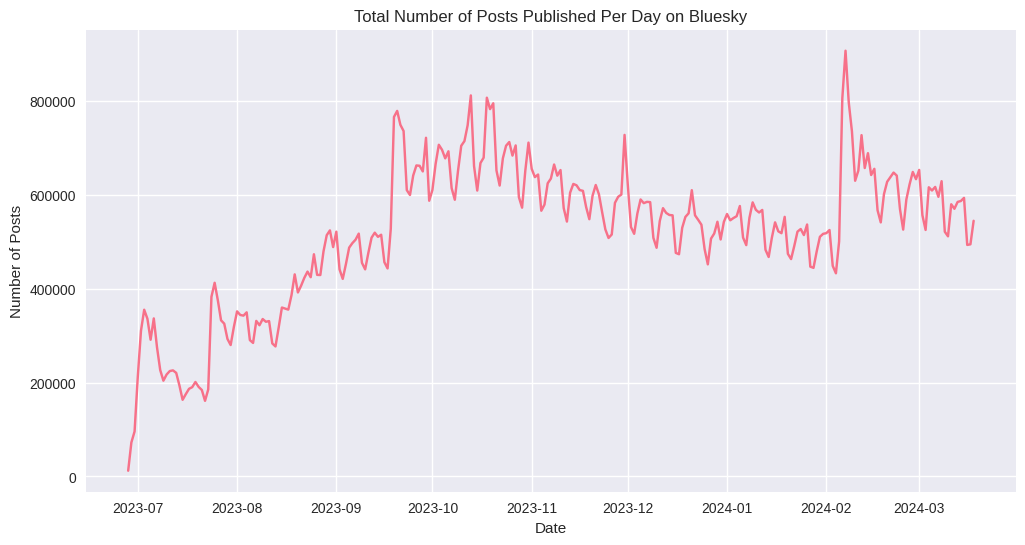

In [ ]:
#groupby data by per day
posts_per_day= user_post_stats_per_day.groupby('date')['post_count'].sum()
#plot the graph
plt.figure(figsize=(12, 6))
plt.plot(posts_per_day.index, posts_per_day.values, linestyle='-')
plt.title('Total Number of Posts Published Per Day on Bluesky')
plt.xlabel('Date')
plt.grid(True)
plt.ylabel('Number of Posts')


It looks like there is a periodic pattern in the data. Let's find out what is is.

### Task 2.2. - *Weekend whispers* (14 points)

Timeseries data over a quite long timespan (like our posts per day on Bluesky that we just plotted) is behaving the way it is often due to different components: a general trend (is the posting activity going up or down?), a seasonality (is there a repeating pattern?) and residuals (were there some unexpected events?).

One way to disentangle those components is Season-Trend decomposition using LOESS (STL).

STL is a powerful tool to help us understand more in detail what drives the daily posting activity on Bluesky. However, to apply STL to our dataset, we have to specify what kind of periodic pattern or seasonality we expect. Besides guessing, we can have a look at our data and try to find a periodic pattern that we can then give to STL. Feel free though to think about what kind of seasonalities one could expect in data like ours.

#### Task 2.2.1. - Frequency spectrum (6 points)

Explore whether the number of daily posts follows any periodic pattern (i.e., if certain posting behaviors repeat regularly over time). To do this, use the `periodogram` function from `scipy.signal`, which estimates the power spectral density (PSD) of the time series. A PSD shows how much of the total variance ("power") in the timeseries is associated with different frequencies. Although the function outputs frequencies (how often something happens in cycles per day), we're typically more interested in periods (length of one full circle in days), since we're looking for patterns that repeat every X days (hint: frequency = 1 / period). When using the `periodogram` function, we’re mainly interested in the periodical components of the timeseries. You may want to account for trends or non-periodical components using the inbuilt detrending argument.

Plot the power (y-axis) for each number of days until and including 10 (x-axis). What is the main frequency in the data according to your plot? Highlight the peak power of your plot with a differently colored vertical line.

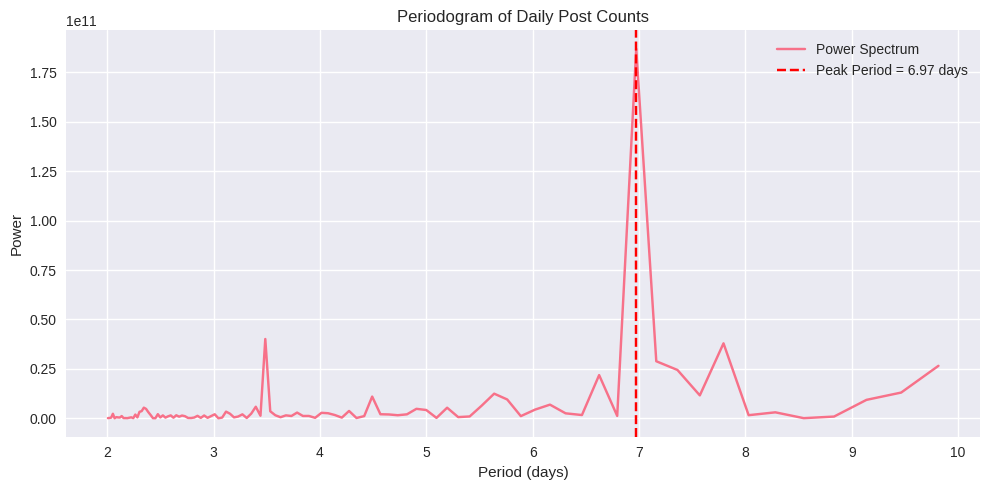

Main periodic pattern: ~6.97 days (peak power = 186944838534.4376)


In [ ]:
# Compute the periodogram
frequencies, power = periodogram(posts_per_day, detrend='linear')

# Convert frequencies (cycles per day) to periods (days per cycle)
periods = 1 / frequencies

# Filter: keep only period of 10 days
mask = periods <= 10
periods = periods[mask]
power = power[mask]

# Identify the main frequency
peak_idx = np.argmax(power)
peak_period = periods[peak_idx]
peak_power = power[peak_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(periods, power, label='Power Spectrum')
plt.axvline(peak_period, color='red', linestyle='--', label=f'Peak Period = {peak_period:.2f} days')
plt.title('Periodogram of Daily Post Counts')
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Main periodic pattern: ~{peak_period:.2f} days (peak power = {peak_power:.4f})")


#### Task 2.2.2. - Seasonal decomposition (5 points)

Now that you have the period you want to investigate, decompose the time series with the `statsmodels.tsa.seasonal.STL` function to disentangle the seasonal pattern from the overall trend and unexpected bursts or drops (residuals). Use the argument `robust=True` to be less influenced by the sudden jumps in the time-series data. Plot the original timeseries as well as the `trend`, `seasonal`, and `residual` components and extract the `seasonal` time series.

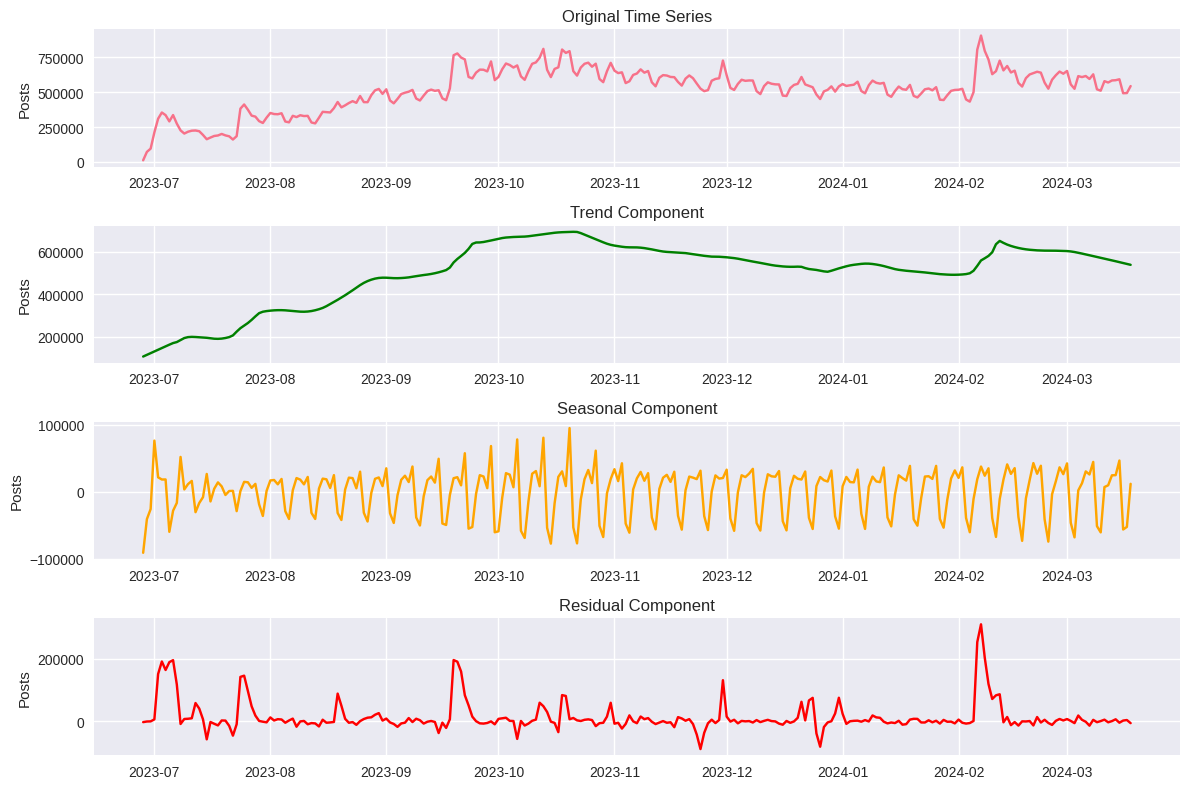

In [ ]:
# Choose period length ( 7 for weekly seasonality)
season_length =7

# Apply STL decomposition
stl = STL(posts_per_day, period=season_length, robust=True)
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
resid = result.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(posts_per_day, label='Original')
plt.title('Original Time Series')
plt.ylabel('Posts')

plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='green')
plt.title('Trend Component')
plt.ylabel('Posts')

plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal', color='orange')
plt.title('Seasonal Component')
plt.ylabel('Posts')

plt.subplot(4, 1, 4)
plt.plot(resid, label='Residual', color='red')
plt.title('Residual Component')
plt.ylabel('Posts')

plt.tight_layout()
plt.show()


A clear weekly seasonal pattern can be observed.

Also a noticeable increase in February 2024, visible in both the trend and residuals, is revealed by the seasonal decomposition. What might explain the increase in activity during this period?

Just by looking at your plot of the STL's trend, give a statement/interpretation regarding the general development of posting activity on Bluesky.

**Response**
A noticeable increasing trajectory at the start till Nov 2023 then s slitelly descrease but it recover in Feb 2024.But see at the residual component the there is also some error.

#### Task 2.2.3. - Weekday effect (3 points)

Add a column `day_of_week` to the time series contained in the `seasonal` property of the STL decomposition based on the datetime index. Plot the average seasonal effect for every day of the week as a bar plot. On which days are the users more active and on which days are they least active?

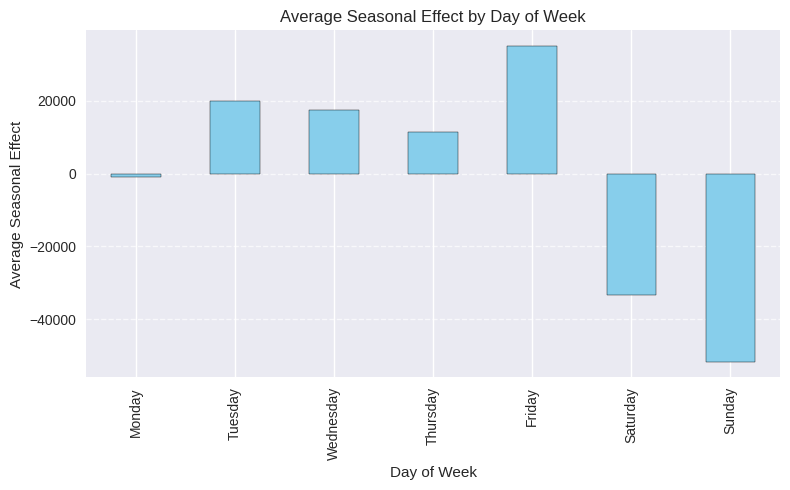

In [ ]:
# Step 1: Convert seasonal to DataFrame
seasonal_df = result.seasonal.to_frame(name='seasonal')
seasonal_df['day_of_week'] = seasonal_df.index.day_name()

# Step 2: Compute average seasonal effect per weekday
avg_seasonal_by_weekday = (
    seasonal_df.groupby('day_of_week')['seasonal']
    .mean()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']))

# Step 3: Plot the results
plt.figure(figsize=(8, 5))
avg_seasonal_by_weekday.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Average Seasonal Effect by Day of Week')
plt.ylabel('Average Seasonal Effect')
plt.xlabel('Day of Week')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Task 2.3. - Sentiment Data (2 points)

Plot the user sentiment and the average post sentiment over time and calculate the correlation between the two timeseries.

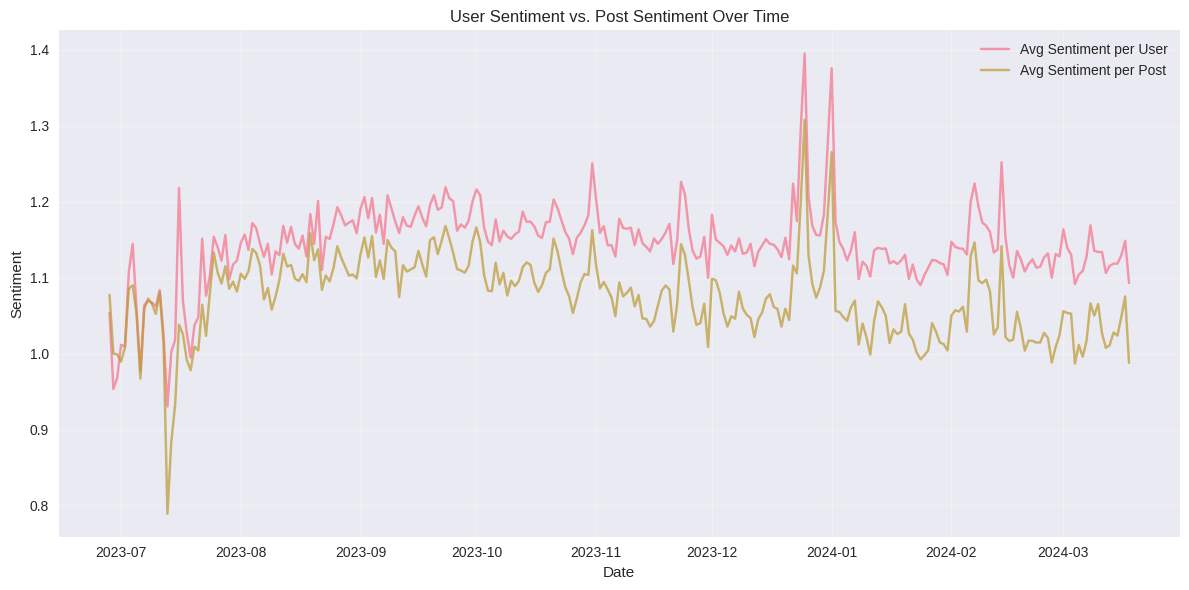

 Pearson correlation: 0.848
 p-value: 2.14e-74


In [ ]:
from scipy.stats import pearsonr

# Step 1: Plot the sentiment timeseries
plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['avg_user_sentiment'], label='Avg Sentiment per User', alpha=0.7)
plt.plot(daily_summary.index, daily_summary['avg_sentiment_posts'], label='Avg Sentiment per Post', alpha=0.7)
plt.title('User Sentiment vs. Post Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Step 2: Calculate Pearson correlation
# Drop missing values to avoid NaNs during correlation
clean_df = daily_summary[['avg_user_sentiment', 'avg_sentiment_posts']].dropna()
corr, pval = pearsonr(clean_df['avg_user_sentiment'], clean_df['avg_sentiment_posts'])

print(f" Pearson correlation: {corr:.3f}")
print(f" p-value: {pval:.3g}")


### Task 2.4. - *Monday Blues?* (4 points)

#### Task 2.4.1. - Seasonal decomposition (2 points)

Repeat the same steps for seasonal decomposition and apply it now to the sentiment data using the function `statsmodels.tsa.seasonal.STL`. You do not need to do the frequency spectrum analysis again. We take the a-priori period of 7 days.

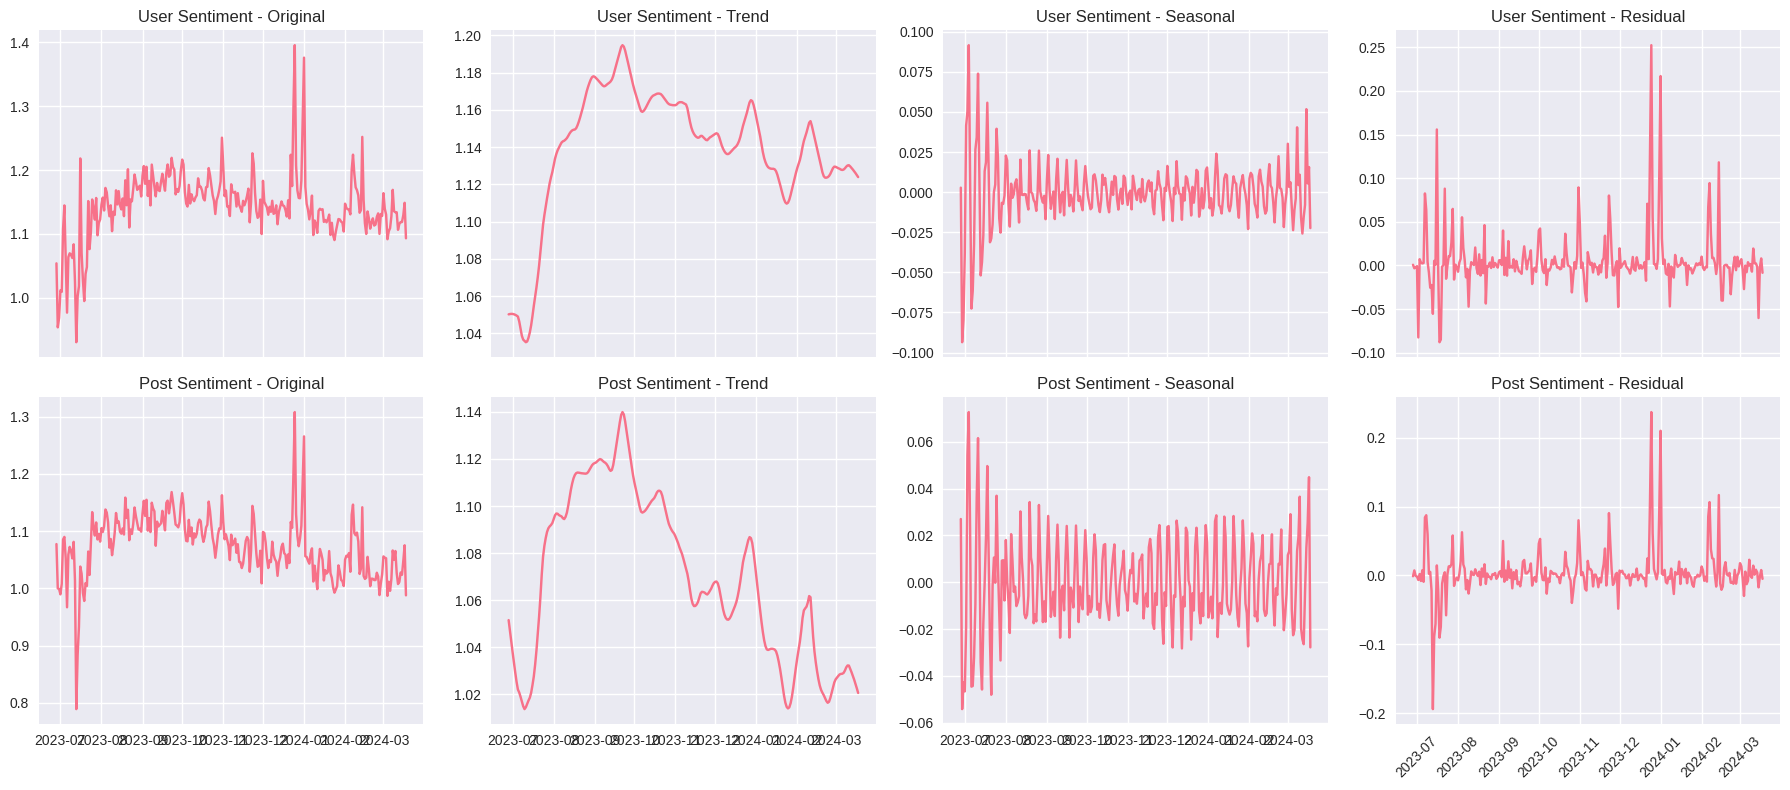

In [ ]:
# Decompose user sentiment
stl_user = STL(daily_summary['avg_user_sentiment'], period=7, robust=True)
res_user = stl_user.fit()

# Decompose post sentiment
stl_post = STL(daily_summary['avg_sentiment_posts'], period=7, robust=True)
res_post = stl_post.fit()

# Plot results
fig, axes = plt.subplots(2, 4, figsize=(18, 8), sharex=True)

# Plot user sentiment decomposition
axes[0, 0].plot(daily_summary.index, daily_summary['avg_user_sentiment'], label='Original')
axes[0, 0].set_title('User Sentiment - Original')
plt.xticks(rotation=45)

axes[0, 1].plot(res_user.trend)
axes[0, 1].set_title('User Sentiment - Trend')
plt.xticks(rotation=45)

axes[0, 2].plot(res_user.seasonal)
axes[0, 2].set_title('User Sentiment - Seasonal')
plt.xticks(rotation=45)

axes[0, 3].plot(res_user.resid)
axes[0, 3].set_title('User Sentiment - Residual')
plt.xticks(rotation=45)

# Plot post sentiment decomposition
axes[1, 0].plot(daily_summary.index, daily_summary['avg_sentiment_posts'], label='Original')
axes[1, 0].set_title('Post Sentiment - Original')
plt.xticks(rotation=45)

axes[1, 1].plot(res_post.trend)
axes[1, 1].set_title('Post Sentiment - Trend')
plt.xticks(rotation=45)

axes[1, 2].plot(res_post.seasonal)
axes[1, 2].set_title('Post Sentiment - Seasonal')
plt.xticks(rotation=45)

axes[1, 3].plot(res_post.resid)
axes[1, 3].set_title('Post Sentiment - Residual')

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


Plot the decomposition of `trend`, `residual`, and `seasonal` components.

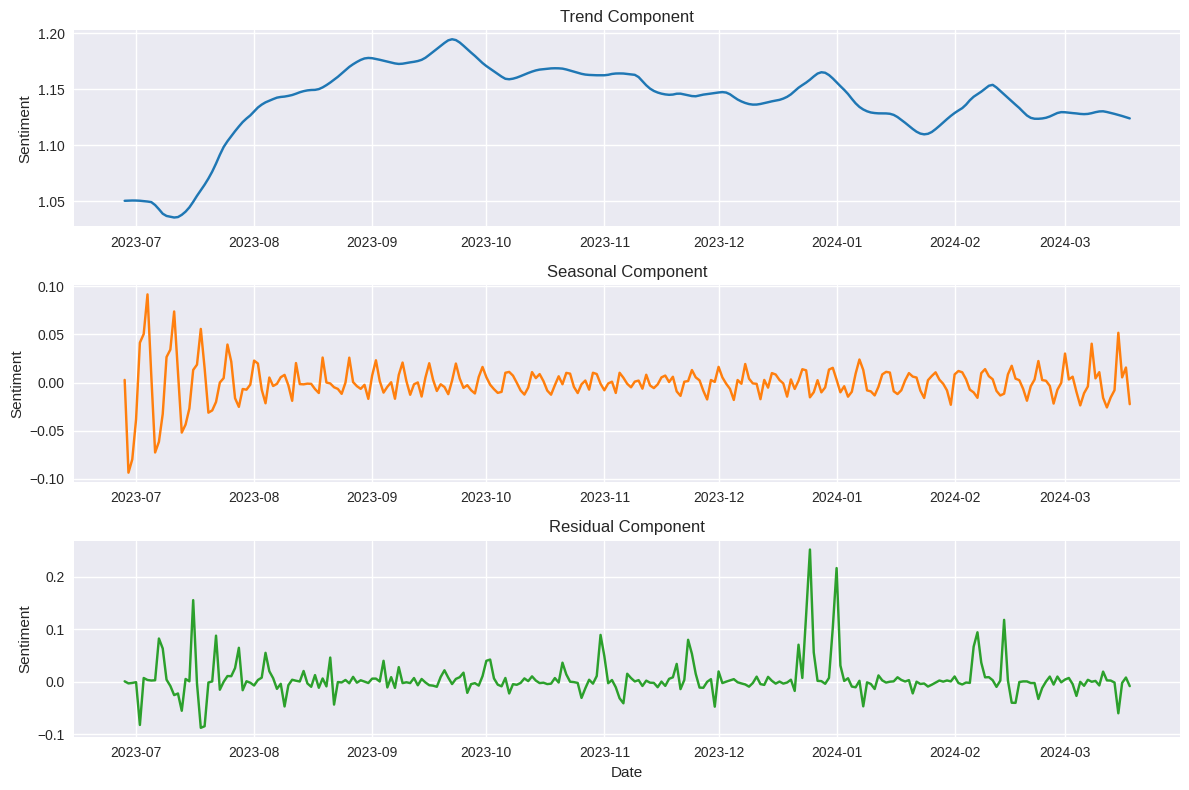

In [ ]:

# Perform STL decomposition on avg_sentiment_user
stl = STL(daily_summary['avg_user_sentiment'], period=7, robust=True)
res = stl.fit()

# Plot the components
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(res.trend, label='Trend', color='tab:blue')
plt.title('Trend Component')
plt.ylabel('Sentiment')

plt.subplot(3, 1, 2)
plt.plot(res.seasonal, label='Seasonal', color='tab:orange')
plt.title('Seasonal Component')
plt.ylabel('Sentiment')

plt.subplot(3, 1, 3)
plt.plot(res.resid, label='Residual', color='tab:green')
plt.title('Residual Component')
plt.ylabel('Sentiment')
plt.xlabel('Date')

plt.tight_layout()
plt.show()


Name two events that can be seen in the residuals.

#### Task 2.4.2. - Weekday effect (2 points)

Plot the effect of weekday onto the average sentiment. What do you see?

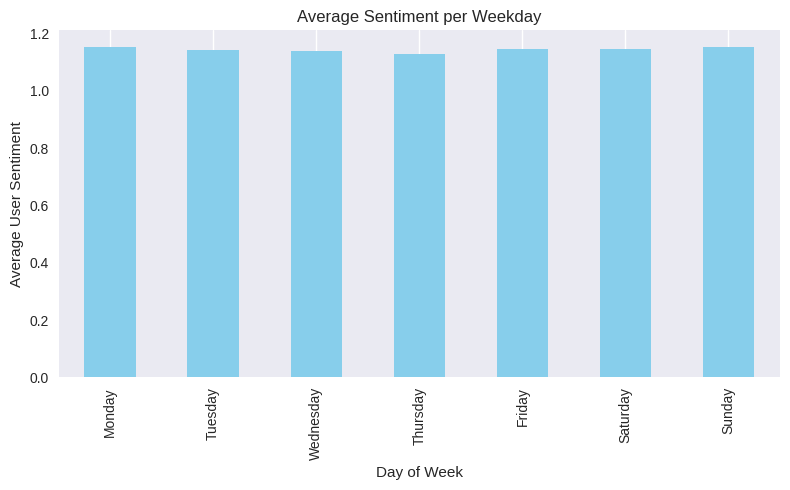

In [ ]:

daily_summary = daily_summary.copy()
daily_summary.index = pd.to_datetime(daily_summary.index)

# Add weekday column
daily_summary['day_of_week'] = daily_summary.index.day_name()

# Group by day of the week and compute mean sentiment
weekday_sentiment = daily_summary.groupby('day_of_week')['avg_user_sentiment'].mean()

# Reorder days of the week
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sentiment = weekday_sentiment.reindex(weekday_order)

# Plot
plt.figure(figsize=(8, 5))
weekday_sentiment.plot(kind='bar', color='skyblue')
plt.title('Average Sentiment per Weekday')
plt.ylabel('Average User Sentiment')
plt.xlabel('Day of Week')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Task 2.5. - Highly active users (2 points)

Last but not least, lets look at the distribution of the average number of posts per day of Bluesky's users. Transform the data so that a distribution is visible. What do you see?

In [ ]:

post_activity = user_stats['avg_daily_post'].dropna()

# Plot both raw and log-transformed histogram
plt.figure(figsize=(14, 5))
# Log-transformed (log1p to include zeros)
plt.subplot(1, 2, 2)
plt.hist(np.log1p(post_activity), bins=50, color='salmon', edgecolor='k')
plt.title('Log-Transformed Distribution (log)')
plt.xlabel('log(1 + Average Posts per Day)')
plt.ylabel('Number of Users')
plt.grid(True)

plt.tight_layout()
plt.show()


___
## Task 3: Statistics (17 points)

### Task 3.1. - Weekday effects on posting behaviour (6 points)

To see if the effects of the weekday onto the number of posts is significant, we use a linear regression to gain a statistical measure. Regress the extracted seasonal pattern from the day of the week. Read yourself about the dummy variable trap and avoid it by **not** including an intercept. Think about what this means or how to interpret the model and its results then respectively and remember what the seasonal component reflects (or read again about it). Then report the overall statistic for the model, and the statistics for the effects of the different weekdays, using as significance level an &alpha; of 0.05, and interpret the results.

In [ ]:
import statsmodels.formula.api as smf
model=smf.ols("seasonal ~ C(day_of_week)", data=daily_summary).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               seasonal   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     95.57
Date:                Sun, 03 Aug 2025   Prob (F-statistic):           1.13e-62
Time:                        19:51:01   Log-Likelihood:                -2992.1
No. Observations:                 265   AIC:                             5998.
Df Residuals:                     258   BIC:                             6023.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    3.493e+04   3186.327     10.961      0.000    2.87e+04    4.12e+04
C(day_of_week)[T.Monday]      -3.6e+04   4506.147     -7.989      0.000   -4.49e+04   -2.71e+04
C(day_of_week)[T.Saturday]  -6.836e+04   4506.147    -15.171      0.000   -7.72e+04   -5.95e+04
C(day_of_week)[T.Sunday]    -8.652e+04   4506.147    -19.201      0.000   -9.54e+04   -7.77e+04
C(day_of_week)[T.Thursday]  -2.348e+04   4506.147     -5.211      0.000   -3.24e+04   -1.46e+04
C(day_of_week)[T.Tuesday]   -1.509e+04   4536.492     -3.326      0.001    -2.4e+04   -6154.611
C(day_of_week)[T.Wednesday]  -1.74e+04   4506.147     -3.861      0.000   -2.63e+04   -8523.018
==============================================================================
Omnibus:                       63.384   Durbin-Watson:                   1.463
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1166.736
Skew:                           0.291   Prob(JB):                    4.43e-254
Kurtosis:                      13.263   Cond. No.                         7.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As rigorous statisticians we need to do a correction for multiple comparisons since we are testing 7 times. Do a correction for multiple comparisons. Are the weekday effects still significant?

In [ ]:
# get p-values
p_values = model.pvalues
 # using Bonferroni menthod
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

correction_df = pd.DataFrame({
    'weekday': p_values.index,
    'coefficient': model.params.values,
    'original_p': p_values.values,
    'corrected_p': pvals_corrected,
    'significant_after_correction': reject})

correction_df


,weekday,coefficient,original_p,corrected_p,significant_after_correction
0,Intercept,34926.691352,3.318989e-23,2.323292e-22,True
1,C(day_of_week)[T.Monday],-36000.391956,4.530738e-14,3.171516e-13,True
2,C(day_of_week)[T.Saturday],-68363.195015,1.352972e-37,9.470802e-37,True
3,C(day_of_week)[T.Sunday],-86524.156031,1.226522e-51,8.585652e-51,True
4,C(day_of_week)[T.Thursday],-23481.697818,3.847688e-07,2.693382e-06,True
5,C(day_of_week)[T.Tuesday],-15087.876430,1.009482e-03,7.066376e-03,True
6,C(day_of_week)[T.Wednesday],-17396.528627,1.430261e-04,1.001182e-03,True


### Task 3.2. - Weekday effects on user sentiment (4 points)

We repeat the procedure for the sentiment analysis to see if we can actually infer patterns of effects per weekday. Does this still hold after correction for multiple comparisons? Are weekdays having a stronger effect on posts or sentiment?

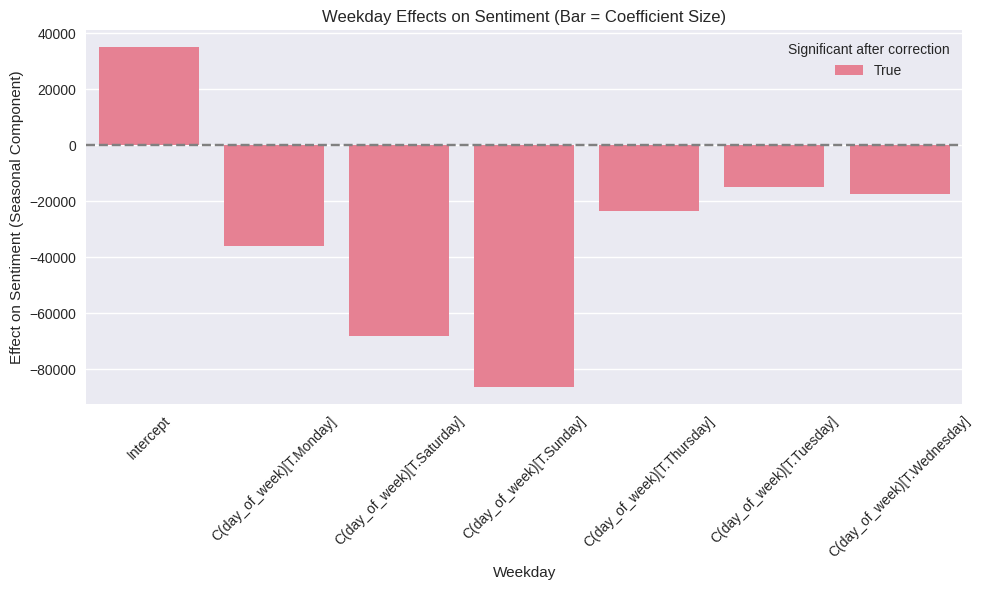

In [ ]:
# Create dummies without intercept
X = pd.get_dummies(seasonal_df["day_of_week"], drop_first=False)
y = seasonal_df["seasonal"]

# Fit linear model without intercept
model_sentiment = sm.OLS(y, X).fit()

plt.figure(figsize=(10, 6))
sns.barplot(data=correction_df, x="weekday", y="coefficient", hue="significant_after_correction")
plt.title("Weekday Effects on Sentiment (Bar = Coefficient Size)")
plt.ylabel("Effect on Sentiment (Seasonal Component)")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.axhline(0, linestyle='--', color='gray')
plt.legend(title="Significant after correction")
plt.tight_layout()
plt.show()


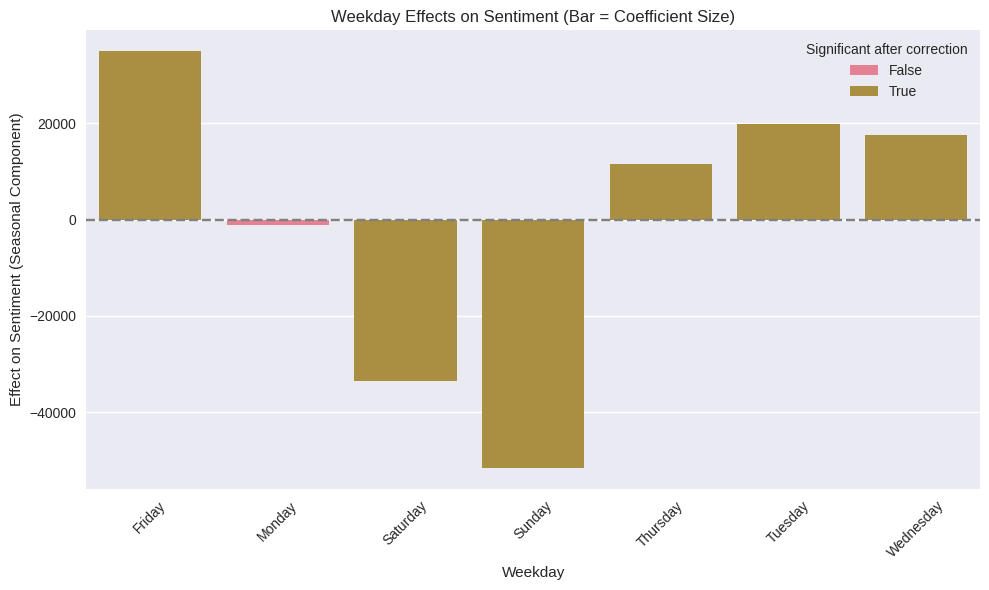

In [ ]:
X= pd.get_dummies(seasonal_df["day_of_week"],)
y=seasonal_df["seasonal"]
model_sentiment=sm.OLS(y,X).fit()

reject, pvals_corrected, _, _ = multipletests(model_sentiment.pvalues, alpha=0.05, method='bonferroni')

sentiment_results = pd.DataFrame({
    "weekday": model_sentiment.params.index,
    "coefficient": model_sentiment.params.values,
    "original_p": model_sentiment.pvalues.values,
    "corrected_p": pvals_corrected,
    "significant_after_correction": reject})

plt.figure(figsize=(10, 6))
sns.barplot(data=sentiment_results, x="weekday", y="coefficient", hue="significant_after_correction")
plt.title("Weekday Effects on Sentiment (Bar = Coefficient Size)")
plt.ylabel("Effect on Sentiment (Seasonal Component)")
plt.xlabel("Weekday")
plt.xticks(rotation=45)
plt.axhline(0, linestyle='--', color='gray')
plt.legend(title="Significant after correction")
plt.tight_layout()
plt.show()


### Task 3.3. - Bot-like behavior on user sentiment (7 points)

Now we will have a look at the user data. In the preprocessing part, we have already created a dataframe with features characterising users. Since some users are posting way more than the average number of posts per day, it looks like bots are being on the network that create large number of posts. Unfortunately, our dataset doesn't provide labels classifying whether a user is a bot or not. But since we have previously created a list of features, we can now try to make use of them to come up with some rules.

Create a new column `is_bot` in the dataset based on the following logic:\
A user is labeled as a bot if the two following conditions are met:
1. Activity is very high: `post_count_total` > 1000
2. Posting frequency is too regular: `cv_days_between_posts` < 0.5

In Task 1.2, several features were computed based on the time between posts for each user: `"mean_days_between_posts", "median_days_between_posts", "std_days_between_posts", "cv_days_between_posts"`.

However, some users are missing one or more of these values — for example, users who posted only once or not at all. Remove all rows from the dataset where any of these four features is missing (NaN).

In [ ]:
user_stats["is_bot"]=((user_stats["total_post"]>1000) & (user_stats["cv_days_between_posts"]<0.5))


Test whether bots and non-bots differ significantly in the following metrics:
1. `sentiment_mean`
2. `sentiment_std`

For each metric:
- Plot both distributions (bots and non-bots) for both metrics with appropriate plots.
- Choose an appropriate test (parametric, non-parametric, or bootstrapping)
- Justify and check the assumptions of your test
- Report your p-value, and whether it is significant.

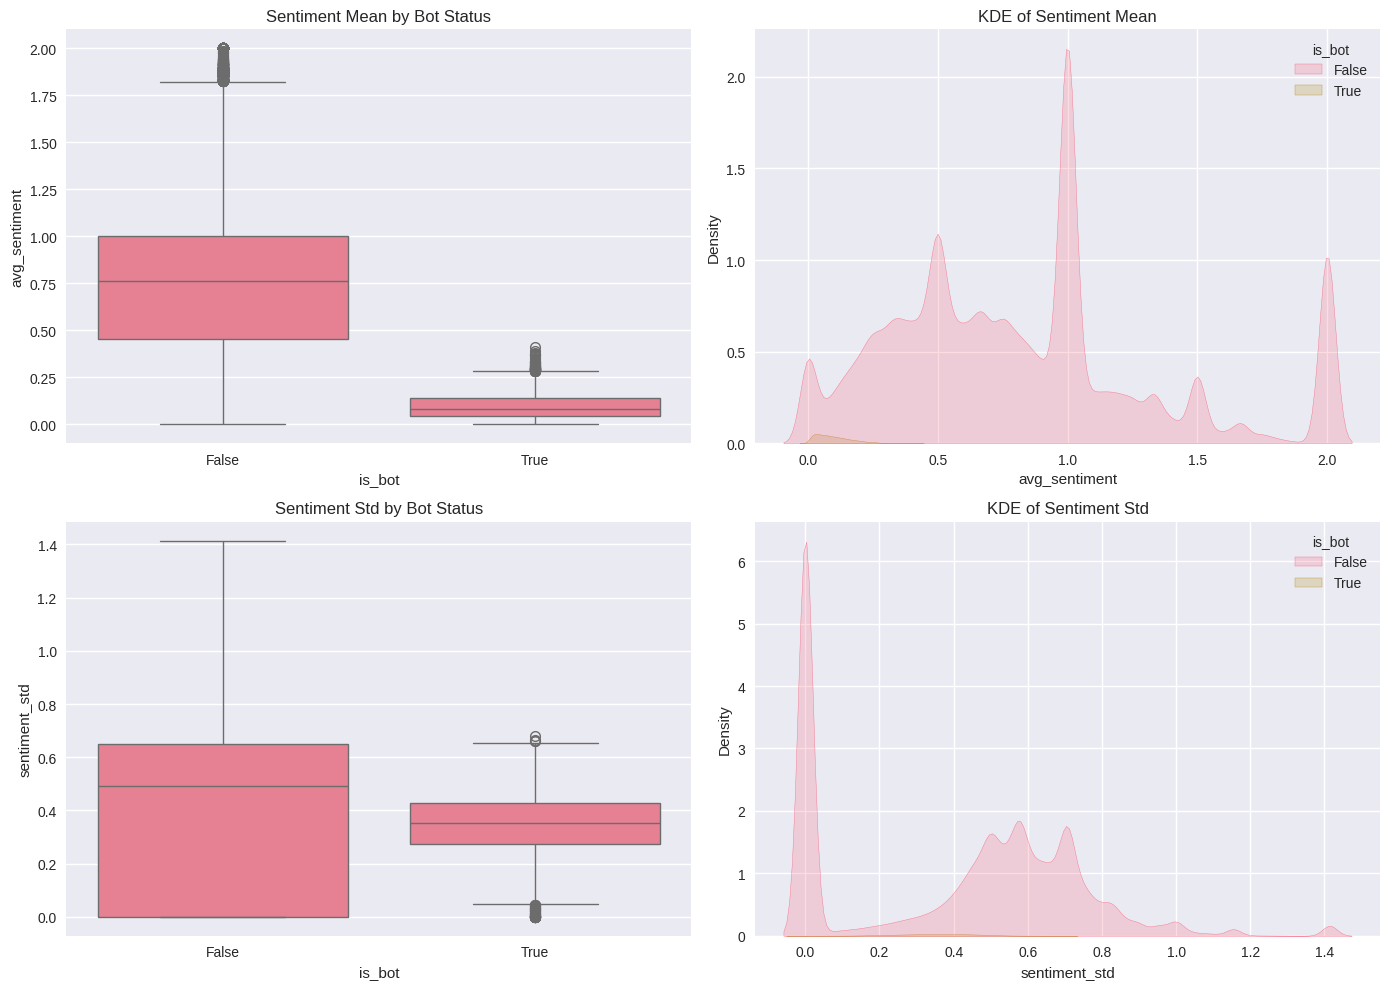

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# box plots
sns.boxplot(data=user_stats, x='is_bot', y='avg_sentiment', ax=axes[0, 0])
axes[0, 0].set_title("Sentiment Mean by Bot Status")

sns.boxplot(data=user_stats, x='is_bot', y='sentiment_std', ax=axes[1, 0])
axes[1, 0].set_title("Sentiment Std by Bot Status")

# KDE plots
sns.kdeplot(data=user_stats, x='avg_sentiment', hue='is_bot', ax=axes[0, 1], fill=True)
axes[0, 1].set_title("KDE of Sentiment Mean")

sns.kdeplot(data=user_stats, x='sentiment_std', hue='is_bot', ax=axes[1, 1], fill=True)
axes[1, 1].set_title("KDE of Sentiment Std")

plt.tight_layout()
plt.show()


By the above graphs, data is not showing normal distribution (skewed), and the variences of both is bot and non-bot is not equal.

With these assumptions Non-parapmetric Mann–Whitney U tests is best for the this tpye of disribution

In [ ]:
bots = user_stats[user_stats["is_bot"] == True]
non_bots = user_stats[user_stats["is_bot"] == False]

print("\nMann–Whitney U tests:")
u_stat_mean, p_mean = mannwhitneyu(bots["avg_sentiment"], non_bots["avg_sentiment"], alternative='two-sided')
u_stat_std, p_std = mannwhitneyu(bots["sentiment_std"], non_bots["sentiment_std"], alternative='two-sided')
print(f"Sentiment Mean U={u_stat_mean:.2f}, p={p_mean:.4f}")
print(f"Sentiment Std  U={u_stat_std:.2f}, p={p_std:.4f}")


Mann–Whitney U tests:
Sentiment Mean U=598404340.00, p=0.0000
Sentiment Std  U=4467695677.00, p=0.0000


___
## Task 4: Machine Learning (40 points)

### Task 4.1. - Unsupervised learning (15 points)

Instead of relying on hardcoded rules to detect bots, we now turn to unsupervised machine learning to identify users with abnormal behavior patterns.

While we could use our rule-based bot labels to train a supervised model, doing so would only teach the model to replicate the very rules we defined — essentially learning nothing new. Since we are not fully confident that these rules accurately capture what defines a bot, we choose not to use them as ground truth.

However, without labeled examples of bots and non-bots, we cannot apply supervised learning. This is where unsupervised learning methods, such as clustering or anomaly detection, become valuable. These approaches allow us to discover potentially suspicious user behavior without predefined labels and may help surface new patterns that our handcrafted rules might miss.

For this task, we use the Isolation Forest algorithm, a popular method for anomaly detection. An Isolation Forest is an ensemble of many Isolation Trees, hence the name "forest." An ensemble is a technique that combines multiple models to create a stronger, more robust model. While individual models—especially when randomized—may make mistakes or follow inefficient paths, combining many of them (e.g., by averaging or voting) helps reduce the influence of these individual errors and amplify consistent patterns across models.

An Isolation Tree is a [tree](https://en.wikipedia.org/wiki/Tree_(abstract_data_type)) that works by recursively partitioning the data. At each node, it:
- Randomly selects a feature.
- Chooses a random split value between that feature's minimum and maximum within the current subset.
- Splits the data accordingly and repeats the process for each subgroup.

This continues until each data point is isolated in its own leaf or a maximum depth is reached. The intuition behind the method is that anomalies are easier to isolate—they require fewer splits to be separated from the rest of the data.

In the Isolation Forest, we compute an anomaly score for each data point based on the average path length (i.e., number of splits) it takes to isolate that point across all trees. Points with shorter average path lengths are considered more anomalous.

You can read more about Isolation Forests [here](https://www.datacamp.com/tutorial/isolation-forest).

#### Task 4.1.1. - Feature inspection (1 point)

To prepare for unsupervised learning, you need to extract a clean set of numerical features that describe user behavior and engagement. Select and keep only the following columns, which represent meaningful behavioral and engagement metrics: `'post_count_total', 'sentiment_mean', 'sentiment_std', 'replied_count', 'reposted_count', 'quoted_count', 'days_active', 'cv_days_between_posts', 'replied_count_by_others', 'reposted_count_by_others', 'quoted_count_by_others'`

In [ ]:
user_features=user_stats[['total_post', 'avg_sentiment', 'sentiment_std', 'replied_count',
                          'reposted_count','quoted_count','active_days','cv_days_between_posts',
                         'replied_count_by_others', 'reposted_count_by_others', 'quoted_count_by_others']]


#### Task 4.1.3. - IsolationForest (4 points)
Use the selected behavioral and sentiment-based features to detect anomalous users in the dataset using an Isolation Forest. \
Set parameters for reproducibility and comparability:
- Use a fixed `random_state`.
- Set the `contamination` parameter to match the ratio of bots in the dataset, as determined in Task 3.3. This ensures that the Isolation Forest model produces a comparable classification to your earlier rule-based `is_bot` labels for task 4.1.5.

In [ ]:
contamination_ratio=user_stats["is_bot"].mean()

iso_forest=IsolationForest(n_estimators=100,
                           contamination=contamination_ratio, random_state=42).fit(user_features)

user_features["anomaly_label"]=iso_forest.predict(user_features)
user_features["is_bot_forest"]=user_features["anomaly_label"]==-1

user_features[['is_bot_forest']].value_counts()

,count
is_bot_forest,
False,1226945
True,9165


#### Task 4.1.4. - Feature importance (5 points)

After training your IsolationForest, it's important to gain insights into which features influence the model’s decision to classify a user as an outlier. However, the IsolationForest is a black-box model and doesn't provide easily interpretable decision rules or feature importances.

To address this, you will train a surrogate model, such as a simple `DecisionTreeClassifier`, to approximate the behavior of the IsolationForest. A surrogate model is a simpler, interpretable model trained on the same input features, but with labels predicted by the original model. This allows you to understand which features the IsolationForest may be relying on—even if indirectly.

Use the same feature set that was used to train the IsolationForest, but now train a decision tree in a supervised setting, using the outlier labels from the IsolationForest. Convert these to more interpretable labels if needed (e.g., "outlier" vs "no_outlier").

Choose model parameters that keep the tree simple and interpretable — for example, a shallow tree. While the surrogate doesn't need to perfectly replicate the IsolationForest, you should still evaluate how closely it mimics the original model's decisions (e.g., via accuracy or a confusion matrix).

Finally, visualize the decision tree or print its decision rules, and use this to draw conclusions about which features seem to matter most to the IsolationForest.

In [ ]:
X=user_features.iloc[:, :-1] # excluding Last Column (is_bot_forest)
y=user_features["is_bot_forest"]

tree_clf=DecisionTreeClassifier(max_depth=3).fit(X,y)
prediction=tree_clf.predict(X)

print("The Confusion matrix \n", confusion_matrix(y, prediction))
# Classfication

print("The Ckassifiction report :\n", classification_report(y, prediction))


The Confusion matrix 
 [[1226945       0]
 [      0    9165]]
The Ckassifiction report :
               precision    recall  f1-score   support

       False       1.00      1.00      1.00   1226945
        True       1.00      1.00      1.00      9165

    accuracy                           1.00   1236110
   macro avg       1.00      1.00      1.00   1236110
weighted avg       1.00      1.00      1.00   1236110



#### Task 4.1.5. - Anomaly vs rule-based classification (3 points)
Evaluate how well these detected anomalies align with your existing `is_bot` labels from the rule-based approach.

Create a cross-tabulation (confusion matrix-style table) using `pd.crosstab()` and comparing those two classifications/labels. Interpret the results by writing two short observations, for example:
- How well do the two methods agree?
- Are there bots missed by one method but caught by the other?

In [ ]:
# Cross-tabulation between IsolationForest and rule-based bot labels
conf_matrix = pd.crosstab(user_stats['is_bot'], user_features['is_bot_forest'],
                          rownames=['Rule-based (is_bot)'],
                          colnames=['Isolation Forest (is_bot_forest)'],
                          margins=True)

print(conf_matrix)

Isolation Forest (is_bot_forest)    False  True      All
Rule-based (is_bot)                                     
False                             1221914  5028  1226942
True                                 5031  4137     9168
All                               1226945  9165  1236110


#### Task 4.1.6. - Statistical test (2 points)

Test whether anomalies and non-anomalies differ significantly in `sentiment_mean` and `sentiment_std` similarly to Task 3.3. Visualize the distributions of `sentiment_mean` and `sentiment_std`, separately for anomalous users and non-anomalous users.

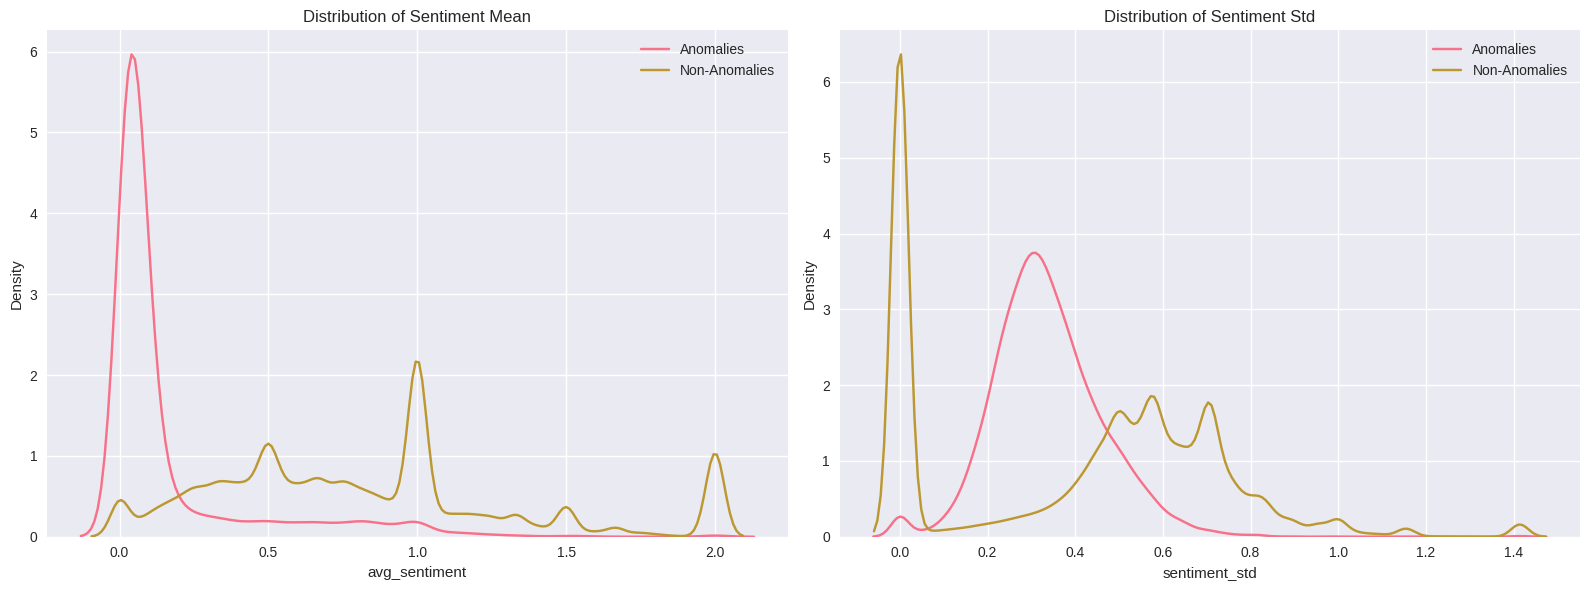

Mann-Whitney U Test for sentiment_mean: U=1186488952.5, p-value=0.00000
Mann-Whitney U Test for sentiment_std: U=4458309116.0, p-value=0.00000


In [ ]:
# Split the data
anomalies = user_features[user_features['is_bot_forest'] == True]
non_anomalies = user_features[user_features['is_bot_forest'] == False]

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(anomalies['avg_sentiment'], label='Anomalies', ax=axes[0])
sns.kdeplot(non_anomalies['avg_sentiment'], label='Non-Anomalies', ax=axes[0])
axes[0].set_title("Distribution of Sentiment Mean")
axes[0].legend()

sns.kdeplot(anomalies['sentiment_std'], label='Anomalies', ax=axes[1])
sns.kdeplot(non_anomalies['sentiment_std'], label='Non-Anomalies', ax=axes[1])
axes[1].set_title("Distribution of Sentiment Std")
axes[1].legend()

plt.tight_layout()
plt.show()

# Statistical tests (non-parametric Mann-Whitney U)
u_mean, p_mean = mannwhitneyu(anomalies['avg_sentiment'], non_anomalies['avg_sentiment'], alternative='two-sided')
u_std, p_std = mannwhitneyu(anomalies['sentiment_std'], non_anomalies['sentiment_std'], alternative='two-sided')

print(f"Mann-Whitney U Test for sentiment_mean: U={u_mean}, p-value={p_mean:.5f}")
print(f"Mann-Whitney U Test for sentiment_std: U={u_std}, p-value={p_std:.5f}")


### Task 4.2. - User Segmentation Analysis (25 points)

The management team at Bluesky wants to gain deeper insights into their user base and has enlisted your help as a data analyst. They are particularly interested in identifying different types of users based on their behavior patterns.

You have already used an Isolation Forest to detect anomalous users. Now, you will perform a comprehensive user segmentation analysis by following these guided steps:


#### Task 4.2.1. - Data Preparation (3 points)
Rerun the Isolation Forest using `contamination='auto'` to identify anomalous users. Focus your subsequent analysis on the users **not** identified as outliers by the model, as these represent more typical user behavior patterns.

- Apply the Isolation Forest with `contamination='auto'`
- Report how many users are classified as anomalous vs. normal
- Create a subset containing only the normal (non-anomalous) users for clustering


In [ ]:
iso_forest_auto=IsolationForest(contamination="auto", random_state=13).fit(X)
user_features["is_bot_forest_auto"]=iso_forest_auto.predict(X)

user_features['is_bot_forest_auto'] = user_features['is_bot_forest_auto'].map({1: False, -1: True})

# outliars counts
outlier_counts = user_features['is_bot_forest_auto'].value_counts()
print("User classification based on IsolationForest (auto):")
print(outlier_counts)

# Subset only normal users
normal_users = user_features[user_features['is_bot_forest_auto'] == False]

User classification based on IsolationForest (auto):
is_bot_forest_auto
False    1144207
True       91903
Name: count, dtype: int64


#### Task 4.2.2. - Feature Engineering (5 points)
Create a subset of features for clustering that capture user behavior patterns:

- Calculate `total_interactions` as the sum of `replied_count`,` reposted_count`, and `quoted_count`
- Create interaction ratio features:
  - `reply_ratio` = replied_count / total_interactions (handle division by zero)
  - `repost_ratio` = reposted_count / total_interactions  
  - `quote_ratio` = quoted_count / total_interactions
- Apply log transformation to the interaction counts (add 1 before logging to handle zeros)
- Explain why these transformations are useful for clustering and understanding users


In [ ]:
#  Total interactions
user_features['total_interactions'] = (
    user_features['replied_count'] + user_features['reposted_count'] + user_features['quoted_count'])

#  Interaction ratios
user_features['reply_ratio'] = np.where(user_features['total_interactions'] == 0, 0, user_features['replied_count'] / user_features['total_interactions'])
user_features['repost_ratio'] = np.where(user_features['total_interactions'] == 0, 0, user_features['reposted_count'] / user_features['total_interactions'])
user_features['quote_ratio'] = np.where(user_features['total_interactions'] == 0, 0, user_features['quoted_count'] / user_features['total_interactions'])

# Log-transformation
user_features['log_replied_count'] =np.log1p(user_features['replied_count'])
user_features['log_reposted_count'] = np.log1p(user_features['reposted_count'])
user_features['log_quoted_count'] = np.log1p(user_features['quoted_count'])


**Total interection** show the preferencs of the individual. **Ratios** shows the activities of individual it will help in clustering.

**Log transformantion** will chanalize the skewnes sof the data. It also reduse the effort of extream values (outliars). This will help clustering  algorithms.


#### Task 4.2.3. - Optimal Cluster Selection (8 points)
Determine the optimal number of clusters using the silhouette method. The silhouette method evaluates clustering quality to help choose the optimal number of clusters k. It balances intra-cluster cohesion and inter-cluster separation. A silhouette score is calculated per k and a score close to 1 signals well-separated clusters, a score close to 0 means overlapping clusters and a negative score indicates misclassified clusters.

- take the features `log_replied`, `log_reposted`, `log_quoted`, `reply_ratio`, `repost_ratio`, `quote_ratio`
- sample a subsample of 100_000 users to increase the speed of clustering
- perform a `StandardScaler` on them
- Test k-means clustering for k = 2 to 8
- Calculate silhouette scores for each k
- Plot the silhouette scores and the inertia scores and select the optimal k
- Justify your choice of the optimal number of clusters


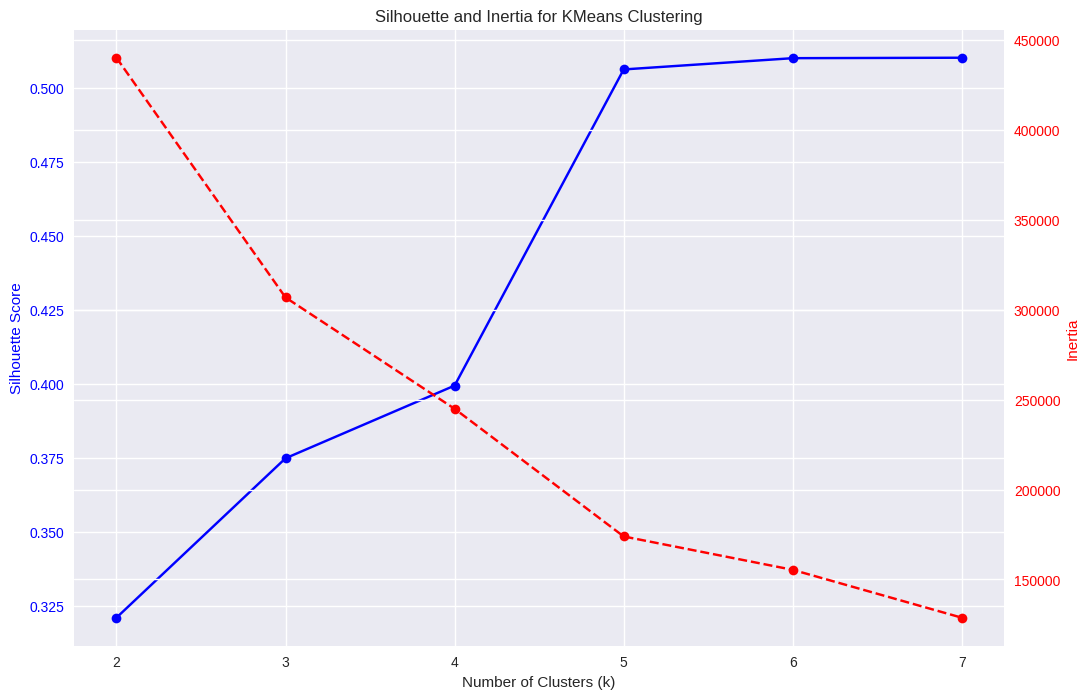

In [ ]:
cluster_features =user_features[['log_replied_count', 'log_reposted_count', 'log_quoted_count',
                                'reply_ratio', 'repost_ratio', 'quote_ratio']]

df_cluster=cluster_features.replace({np.inf:np.nan, -np.inf:np.nan}).dropna()

# Sample of 100,000
df_sample = df_cluster.sample(n=100_000, random_state=42)

# standarize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_sample)

#  Apply KMeans and calculate scores
inertia = []
silhouette = []
ks = range(2, 8)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, labels))

#  Plot
fig, ax1 = plt.subplots()
ax1.plot(ks, silhouette, 'bo-', label='Silhouette Score')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title("Silhouette and Inertia for KMeans Clustering")

ax2 = ax1.twinx()
ax2.plot(ks, inertia, 'ro--', label='Inertia')
ax2.set_ylabel('Inertia', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.show()



#### Task 4.2.4. - Clustering and Visualization (5 points)
Apply k-means clustering with your optimal k and create visualizations:

- Apply k-means with the optimal k
- Create at least two different visualizations of your clusters:
  - PCA projection (2D scatter plot colored by cluster)
  - One additional visualization of your choice (t-SNE, UMAP, or cluster characteristic plots)


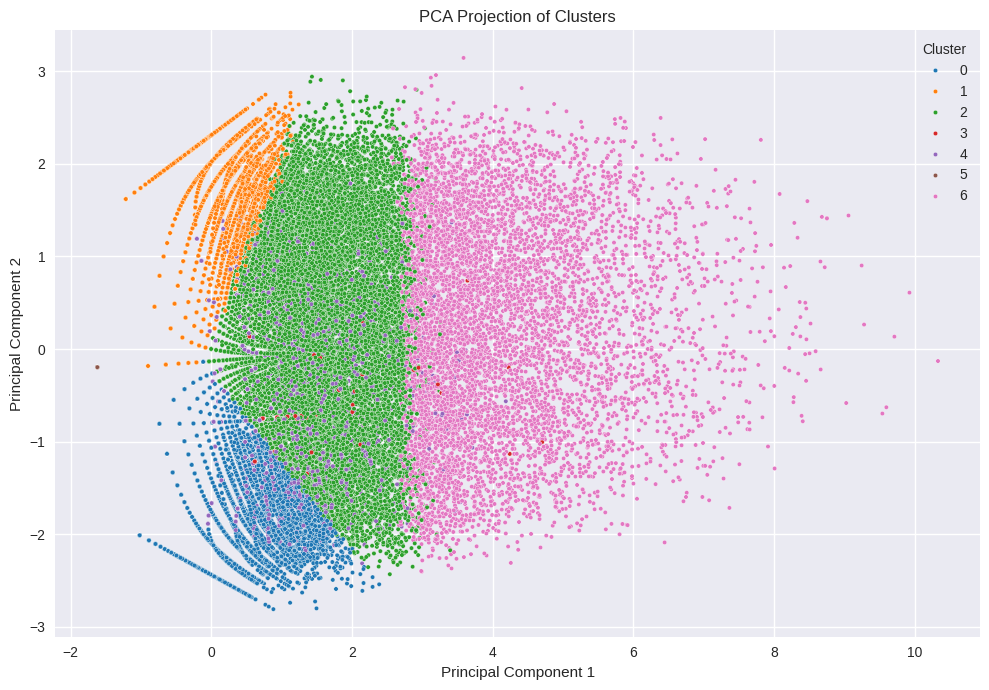

In [ ]:
kmean=KMeans(n_clusters=7, random_state=42).fit(X_scaled)
cluster_labels=kmeans.predict(X_scaled)

#PCA decompsition

pcs=PCA(n_components=2).fit(X_scaled)
X_pca=pcs.transform(X_scaled)

#plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],hue=cluster_labels, palette="tab10", s=10)
plt.title("PCA Projection of Clusters")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc='best')
plt.tight_layout()
plt.show()


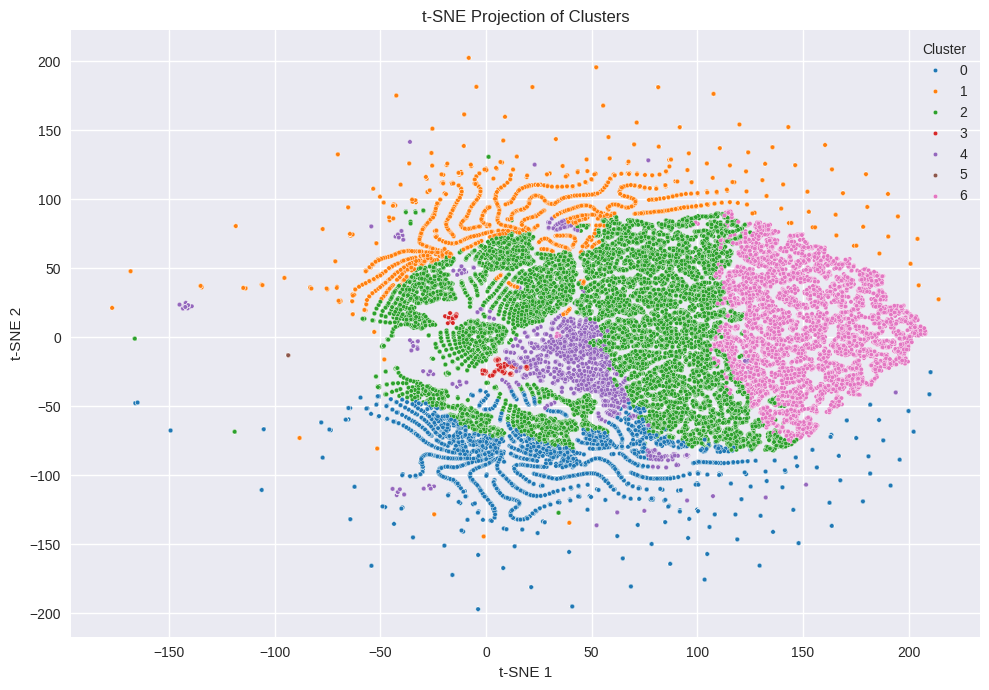

In [ ]:

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels, palette="tab10", s=10)
plt.title("t-SNE Projection of Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Cluster", loc='best')
plt.tight_layout()
plt.show()



#### Task 4.2.5. - Cluster Interpretation (4 points)
Analyze and interpret your clusters to provide actionable insights:

- Calculate mean values of key features for each cluster and plot them
- Plot the proportions of how many users belong to each cluster
- Describe what characterizes each cluster (e.g., high/low activity, behavior preferences)
- Give each cluster a meaningful name that reflects their behavior pattern

In [ ]:
df_sample['cluster'] = cluster_labels

In [ ]:
cluster_summary = df_sample.groupby("cluster").mean()

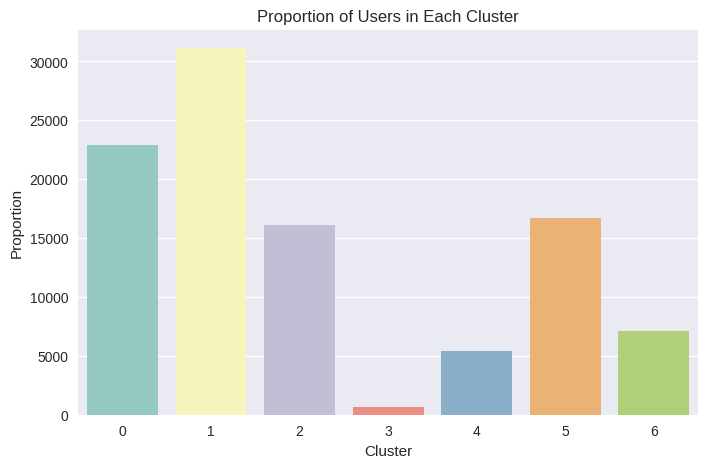

In [ ]:
cluster_counts = df_sample['cluster'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set3")
plt.title("Proportion of Users in Each Cluster")
plt.xlabel("Cluster")
plt.ylabel("Proportion")
plt.show()


**Cluster 1 (Reply oriented)**: Almsot al interaction are replyed, very low in other forms

**Cluster 0 (Enthusiasts Repost)**: Mostly reposted & rarely quoted, moderate post activty

**Cluster 2 (Super engagers)** High across all interaction types.

**Cluster 3 (Quoted)** Mainly qouted & al:most no replyand repost ration

**Cluster 4 (Moderate)** Balance in all most in all areas

**Cluster 5 (silent)** may be a outliar::::

**Cluster 6 (Superactive)** Extreamly high in all types

In [ ]:
cluster_summary.style.background_gradient(cmap='Blues')

,log_replied_count,log_reposted_count,log_quoted_count,reply_ratio,repost_ratio,quote_ratio
cluster,,,,,,
0,0.606126,1.964201,0.133196,0.095192,0.894155,0.010653
1,1.703578,0.446109,0.080762,0.880635,0.111809,0.007556
2,3.499830,3.107925,1.312331,0.538169,0.405732,0.056099
3,0.147890,0.136750,1.002883,0.033678,0.030782,0.935540
4,1.142118,1.385085,1.201001,0.300221,0.408850,0.290929
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,5.522876,5.266091,3.851942,0.490693,0.411835,0.097472
